# 06 Nonlinear classifiers - PART 2 - SVM
---

# Checklist
- [x] RFs performance
- [x] Ensemble size effect
- [x] Linear, RBF SVMs   
   


# Compared conditions
As before I used the similar function to compare accuracy of models created with:
- __SVM models with linear and rbf kernels__, 
- __Different C values__: 
    * regularization parameter
    * I tested C values from 0.1 to 100, and auto setting
    * the strength of the regularization is inversely proportional to C
    * Lower C values shodul decrease potential overfitting of SVM models
- __Different gamma values__ : 
    * coefficient used for ‘rbf’, ‘poly’ and ‘sigmoid’ kernels, 
    * I tested gama values ranging from 0.001 to 10, and "auto" setting equal to 1/n features*X.var
    * Very large gamma may cause overfitting, and it may take a lot of time to caluclate the results, 
    * Gamma value is applied only to SVM models using rbf kernels, and It shoudl be ignored with SVM models using linear kernel. Thus, this condition may be removed in the future. Very large gamma may cause overfitting
- __Extracted features prepaprocessed with PCA or not__, 
- __Models build using different number of principial axes (10, 30 or 250)__


# Answering two questions for nonlinear classifiers:
## Can you do better with SVM than the baseline models from above (ie. logreg, decission trees, knn)  
Yes.   
The validation accuracy of the best performing SVM models (94.4%), was slightly higher then best performign models created using knn, logreg and decission trees (,ax 93%). and it was similar to the best performing models created using random forest approach (94.4%). 
  
## Try with SVMs - does the RBF kernel perform better than the linear one?
It is possible, to build highly performing models both with rbf and linear kernels for swissroad dfataset (eg: 94.4% and 93.6% of validation accuracy, repsectively). However, larger number of very well performing models (accuracy >=90%) were created only using SVM models with linear kernels. Additionally, the calculation was faster and required smaller number of parameters (no gamma used with linear kernel). Finally, SVM models with linear kernels created with different C values had similar perfomance. In contrast, validation accuracy caulated for SVM models with rbf kernels varied greatly depending on C and gamma value, and large number of models generated similar results to the most frequent baseline. CONCLUSION: I woudl use linear kernel for swissroad datset. 



# Config

In [5]:
# ************************************************************************* #
#     Author:   Pawel Rosikiewicz                                           #       
#     Copyrith: IT IS NOT ALLOWED TO COPY OR TO DISTRIBUTE                  #
#               these file without written                                  #
#               persmission of the Author                                   #
#     Contact:  prosikiewicz@gmail.com                                      #
#                                                                           #
# ************************************************************************* #

# Config

# basedir
basedir = '/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution'

# project config 
project_name = "Pawel_Rosikiewicz_EPFLext_Project4"
dataset_name = "swissroads"
subset_names = ["train", "valid", "test"]
module_names = ["imagenet"]
class_colors = {          "car": "orange",
                          "van": "steelblue",
                          "truck": "red",
                          "bike": "forestgreen",
                          "motorcycle" : "purple",
                           "other": "dimgrey"}

# task config
task_name = "SVM" # CAUTION, analyis time depends on parameters used, with grid search, large C value and gamma increase that time expotentially,
train_subset_names = ["train", "valid"] # data subsets, used together in part 1 and in part 3 for ploting image examples and PCA analyis
test_subset_names = ["test"]


# Note:
"""in some cases train, test and valid datasets, may be also subset names of the datasets, 
   this script works by loading selected daset subsets into either train and test category, 
   validation ataset is created automatically, at random fro 30% of train dataset.
   all saved predictions have reference to original images in raw data
   
   SVM -  CAUTION, analyis time depends on parameters used, with grid search, large C value and gamma increase that time expotentially,  
""";

# Load packages

In [6]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import pickle
import warnings
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
import graphviz # allows visualizing decision trees,

# Load custom functions created for the project from basedir/src/utils

In [7]:
os.chdir(basedir)
sys.path.append(basedir)

# my tools, loaded only form basedir, 
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.logreg_tools import my_logredCV, plot_examples_with_predictions_and_proba,plot_examples_with_predictions_and_proba_gamma 
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots

# one of my functions was generating warnign, on copies, despite using proper syntax, 
warnings.filterwarnings("ignore")

# setup paths for the task

In [10]:
PATH_raw = os.path.join(basedir, "data/raw", dataset_name)
PATH_encoded = os.path.join(basedir, "data/interim", dataset_name)
PATH_results = os.path.join(basedir, "data/results", f"{dataset_name}_{task_name}")

# create new direcory for task results, 
try: 
    os.mkdir(PATH_results)
    try:
        os.chdir(PATH_results)
        print("PATH_results was created")
    except:
        print("ERROR: PATH_results was not created correctly")
except: 
    print("file already exist, or PATH_results was not created correctly")

file already exist, or PATH_results was not created correctly, 


# Run grid search to find best performin SVM model and collect results with each model
---
* The fucntion allows comparing all conditions that were described in section introduction, 
* the data are loaded using custom made genberastors, keras image generators,
* train and valid data are mixed and divided again in proportion 0.7:0.3,

In [11]:
# ...........................................................................................
# run grid search, 

# grid for parameter search, 
grid = ParameterGrid({
        'kernel':['rbf', 'linear'],
        'C':[0.1, 1, 10, 100],    # lover C value decreases potential overfitting, large values take a lot of time to complete 
        'gamma':['auto', 0.001, 0.01, 0.1, 1, 10],  # very large gamma > overfitting 
        'pca':[0, 10, 30, 250]
    })
print(len(grid))


# ...........................................................................................
# grid search with cross-validation on parameters provided for logarithmic regression, 
for module_name in module_names:
    print(f"- {module_name} -")
    print(f"{len(grid)} parameter combinations will be evaluated", end=", ")
    print(f"if will take approximately {np.round(len(grid)*100/1000, 1)} min, started: {pd.to_datetime('now')}")
        

    # STEP 1. run grid search, 
    svm_results_list, model_predictions_dict = SVM_grid_search(
        path=PATH_encoded, 
        dataset_name=dataset_name, 
        subset_names_tr=train_subset_names, 
        subset_names_te=test_subset_names, 
        module_names=[module_name], 
        class_encoding=dict(zip(list(class_colors.keys()), list(range(len(class_colors))))), 
        grid=grid, 
        param_names_for_DecisionTreeClassifier=['kernel', 'C', 'gamma'],   # variables for svm in grid search, 
        verbose=False,
        track_progresss=True,
    )

    # STEP 2. save files 
    os.chdir(PATH_results)

    # .. save summary table
    pd.DataFrame(svm_results_list).to_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv", header=True)
        
    # .. save the model_predictions_dict into a pickle file
    with open(f"{task_name}__{module_name}__{dataset_name}__model_predictions_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(model_predictions_dict, file)     
    
    
print("\nDONE....")    


192
- imagenet -
192 parameter combinations will be evaluated, if will take approximately 19.2 min, started: 2020-11-11 13:26:03.538704
0 imagenet _________________________________________ 2020-11-11 13:26:03.539073
................................................................................................................................................................................................
DONE _________________________________________ 2020-11-11 13:28:00.123311


DONE....


# Evaluate models created with grid search
---

### Show top ten best performing models

* classyfication is based on validation accuracy, 

In [12]:
# SHOW TABLE WITH 10 BEST PERFORMINGH MODELS, 
for i, module_name in enumerate(module_names):
    try:
        # reload the data
        os.chdir(PATH_results)
        one_module_summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")
        
        if i==0:
            summary_df = one_module_summary_df   
        else:
            summary_df = pd.concat([summary_df,one_module_summary_df], axis=0)
    except:
        pass
    
# sort summary table 
features_to_display = ["model_ID", "model_acc_valid", "model_acc_train", "baseline_acc_train", "baseline_acc_test", "pca_components_used", "C", 'kernel', 'gamma']
df_sorted = summary_df.sort_values("model_acc_valid", ascending=False).loc[:,features_to_display].head(10)
display(df_sorted.head(10))

model_ID  model_acc_valid  model_acc_train  baseline_acc_train  \
14         14         0.944444         0.986348            0.245734   
6           6         0.944444         0.986348            0.245734   
96         96         0.936508         0.982935            0.245734   
108       108         0.936508         1.000000            0.245734   
107       107         0.936508         0.989761            0.245734   
106       106         0.936508         0.965870            0.245734   
104       104         0.936508         0.993174            0.245734   
103       103         0.936508         1.000000            0.245734   
100       100         0.936508         1.000000            0.245734   
99         99         0.936508         1.000000            0.245734   

     baseline_acc_test  pca_components_used     C  kernel  gamma  
14                0.22                   30   0.1  linear  0.001  
6                 0.22                   30   0.1  linear   auto  
96                0.22                    0  10.0     rbf   auto  
108               0.22                    0  10.0  linear  0.001  
107               0.22                  250  10.0     rbf  0.001  
106               0.22                   30  10.0     rbf  0.001  
104               0.22                    0  10.0     rbf  0.001  
103               0.22                  250  10.0  linear   auto  
100               0.22                    0  10.0  linear   auto  
99                0.22                  250  10.0     rbf   auto

# Compare train and validation accuracy of models created using different combinations of parameters, kernels,  and data preparation approaches
---
* The Table below figures shows the best performing model from each plot, with relevant parameters,

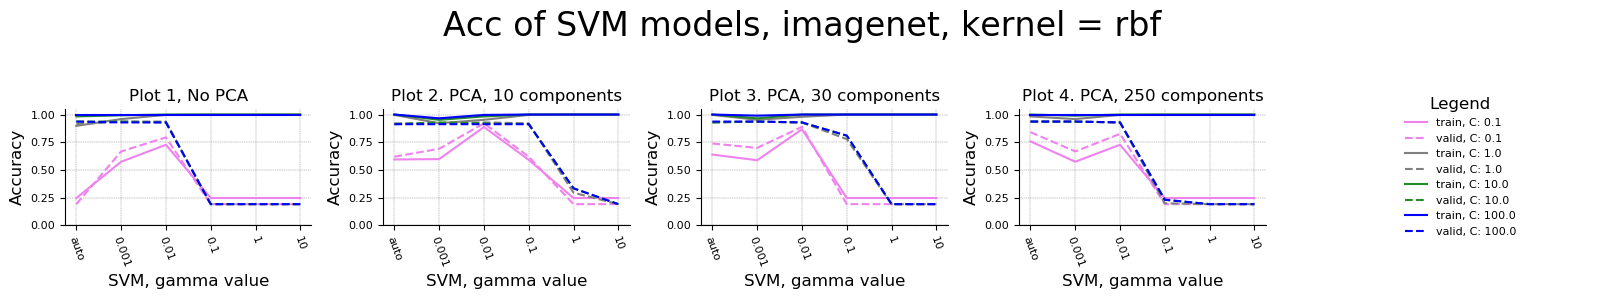

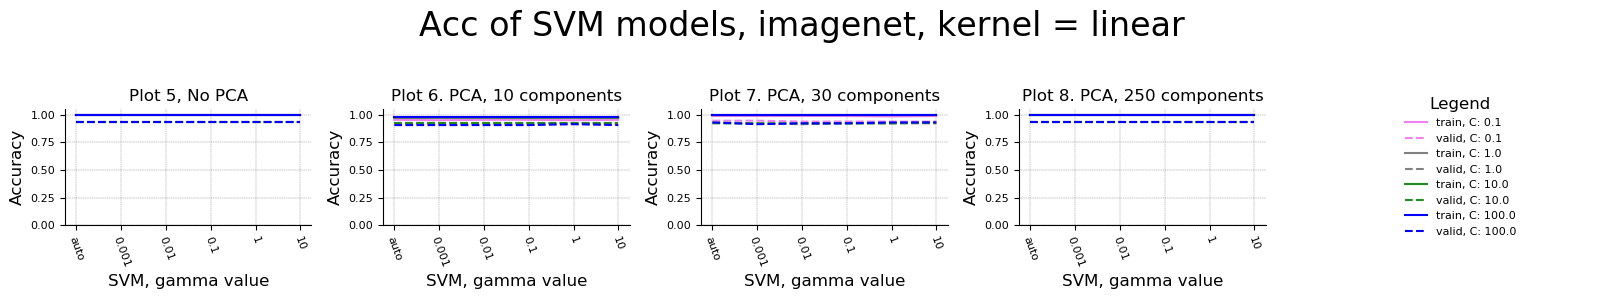

Plot_nr  model_ID method    module  model_acc_train  model_acc_valid  \
6  Plot 7         6    SVM  imagenet         0.986348         0.944444   
0  Plot 1        56    SVM  imagenet         0.959044         0.936508   
2  Plot 3        58    SVM  imagenet         0.952218         0.936508   
3  Plot 4        51    SVM  imagenet         0.982935         0.936508   
4  Plot 5         4    SVM  imagenet         1.000000         0.936508   
7  Plot 8         7    SVM  imagenet         1.000000         0.936508   
1  Plot 2        65    SVM  imagenet         0.952218         0.928571   
5  Plot 6        53    SVM  imagenet         0.969283         0.920635   

   model_acc_test  kernel  pca_components_used  gamma    C  \
6            0.92  linear                   30   auto  0.1   
0            0.94     rbf                    0  0.001  1.0   
2            0.94     rbf                   30  0.001  1.0   
3            0.94     rbf                  250   auto  1.0   
4            0.94  linear                    0   auto  0.1   
7            0.94  linear                  250   auto  0.1   
1            0.94     rbf                   10   0.01  1.0   
5            0.94  linear                   10   auto  1.0   

   baseline_acc_train  baseline_acc_valid  baseline_acc_test  
6            0.245734            0.190476               0.22  
0            0.245734            0.190476               0.22  
2            0.245734            0.190476               0.22  
3            0.245734            0.190476               0.22  
4            0.245734            0.190476               0.22  
7            0.245734            0.190476               0.22  
1            0.245734            0.190476               0.22  
5            0.245734            0.190476               0.22

In [13]:
# plot accuracy results for models created with different parameters
for module_name in module_names:
    
    try:
        
        # reload the data
        os.chdir(PATH_results)
        summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")

        # restore deafult settign for matplolib 
        mpl.rcdefaults() 

        # summary plots and table, 
        best_performing_model_on_each_plot = model_gridsearch_summary_plots(
                data=summary_df, 
                module_names=[module_name],
                fig_title_prefix = f"Acc of {task_name} models, {module_name}, kernel =",
                create_figure = True,
                # ...
                fig_dname        = "kernel",
                subplots_dname   = "pca_components_used",
                xaxis_dname      = "gamma",
                linecolor_dname  = "C",
                linestyle_dnames = ["train", "valid"], # linestyle_dnames correspond to accuracy results in summary table,  
                # ...
                figsize=(16,3),
                fontscale=0.8,
                x_label = "SVM, gamma value",
                y_label = "Accuracy",
                y_limits = (0,1.05),
                subplots_adjust_top=0.65
            )
    
        
        # display summary table with best poerforming models, 
        display(best_performing_model_on_each_plot.sort_values("model_acc_valid", ascending=False))

    except:
        pass

# Show Predictions made with the best performing model for test data
---

* The best model was selected using validation accuracy, from all compared models in that section, 
* border colors arround each picture show true class of that image (see legend, for class-color pairs),
* the groups of images (labelled on top of each group), show classyfication made by the model,
* the probability values displayed on each image were calculated using model.predict_proba() function, 
* Predictions in each group were summarized, on pie plots below the main figure, 
* you may double click on the image to make it larger, 

Found 50 images belonging to 6 classes.


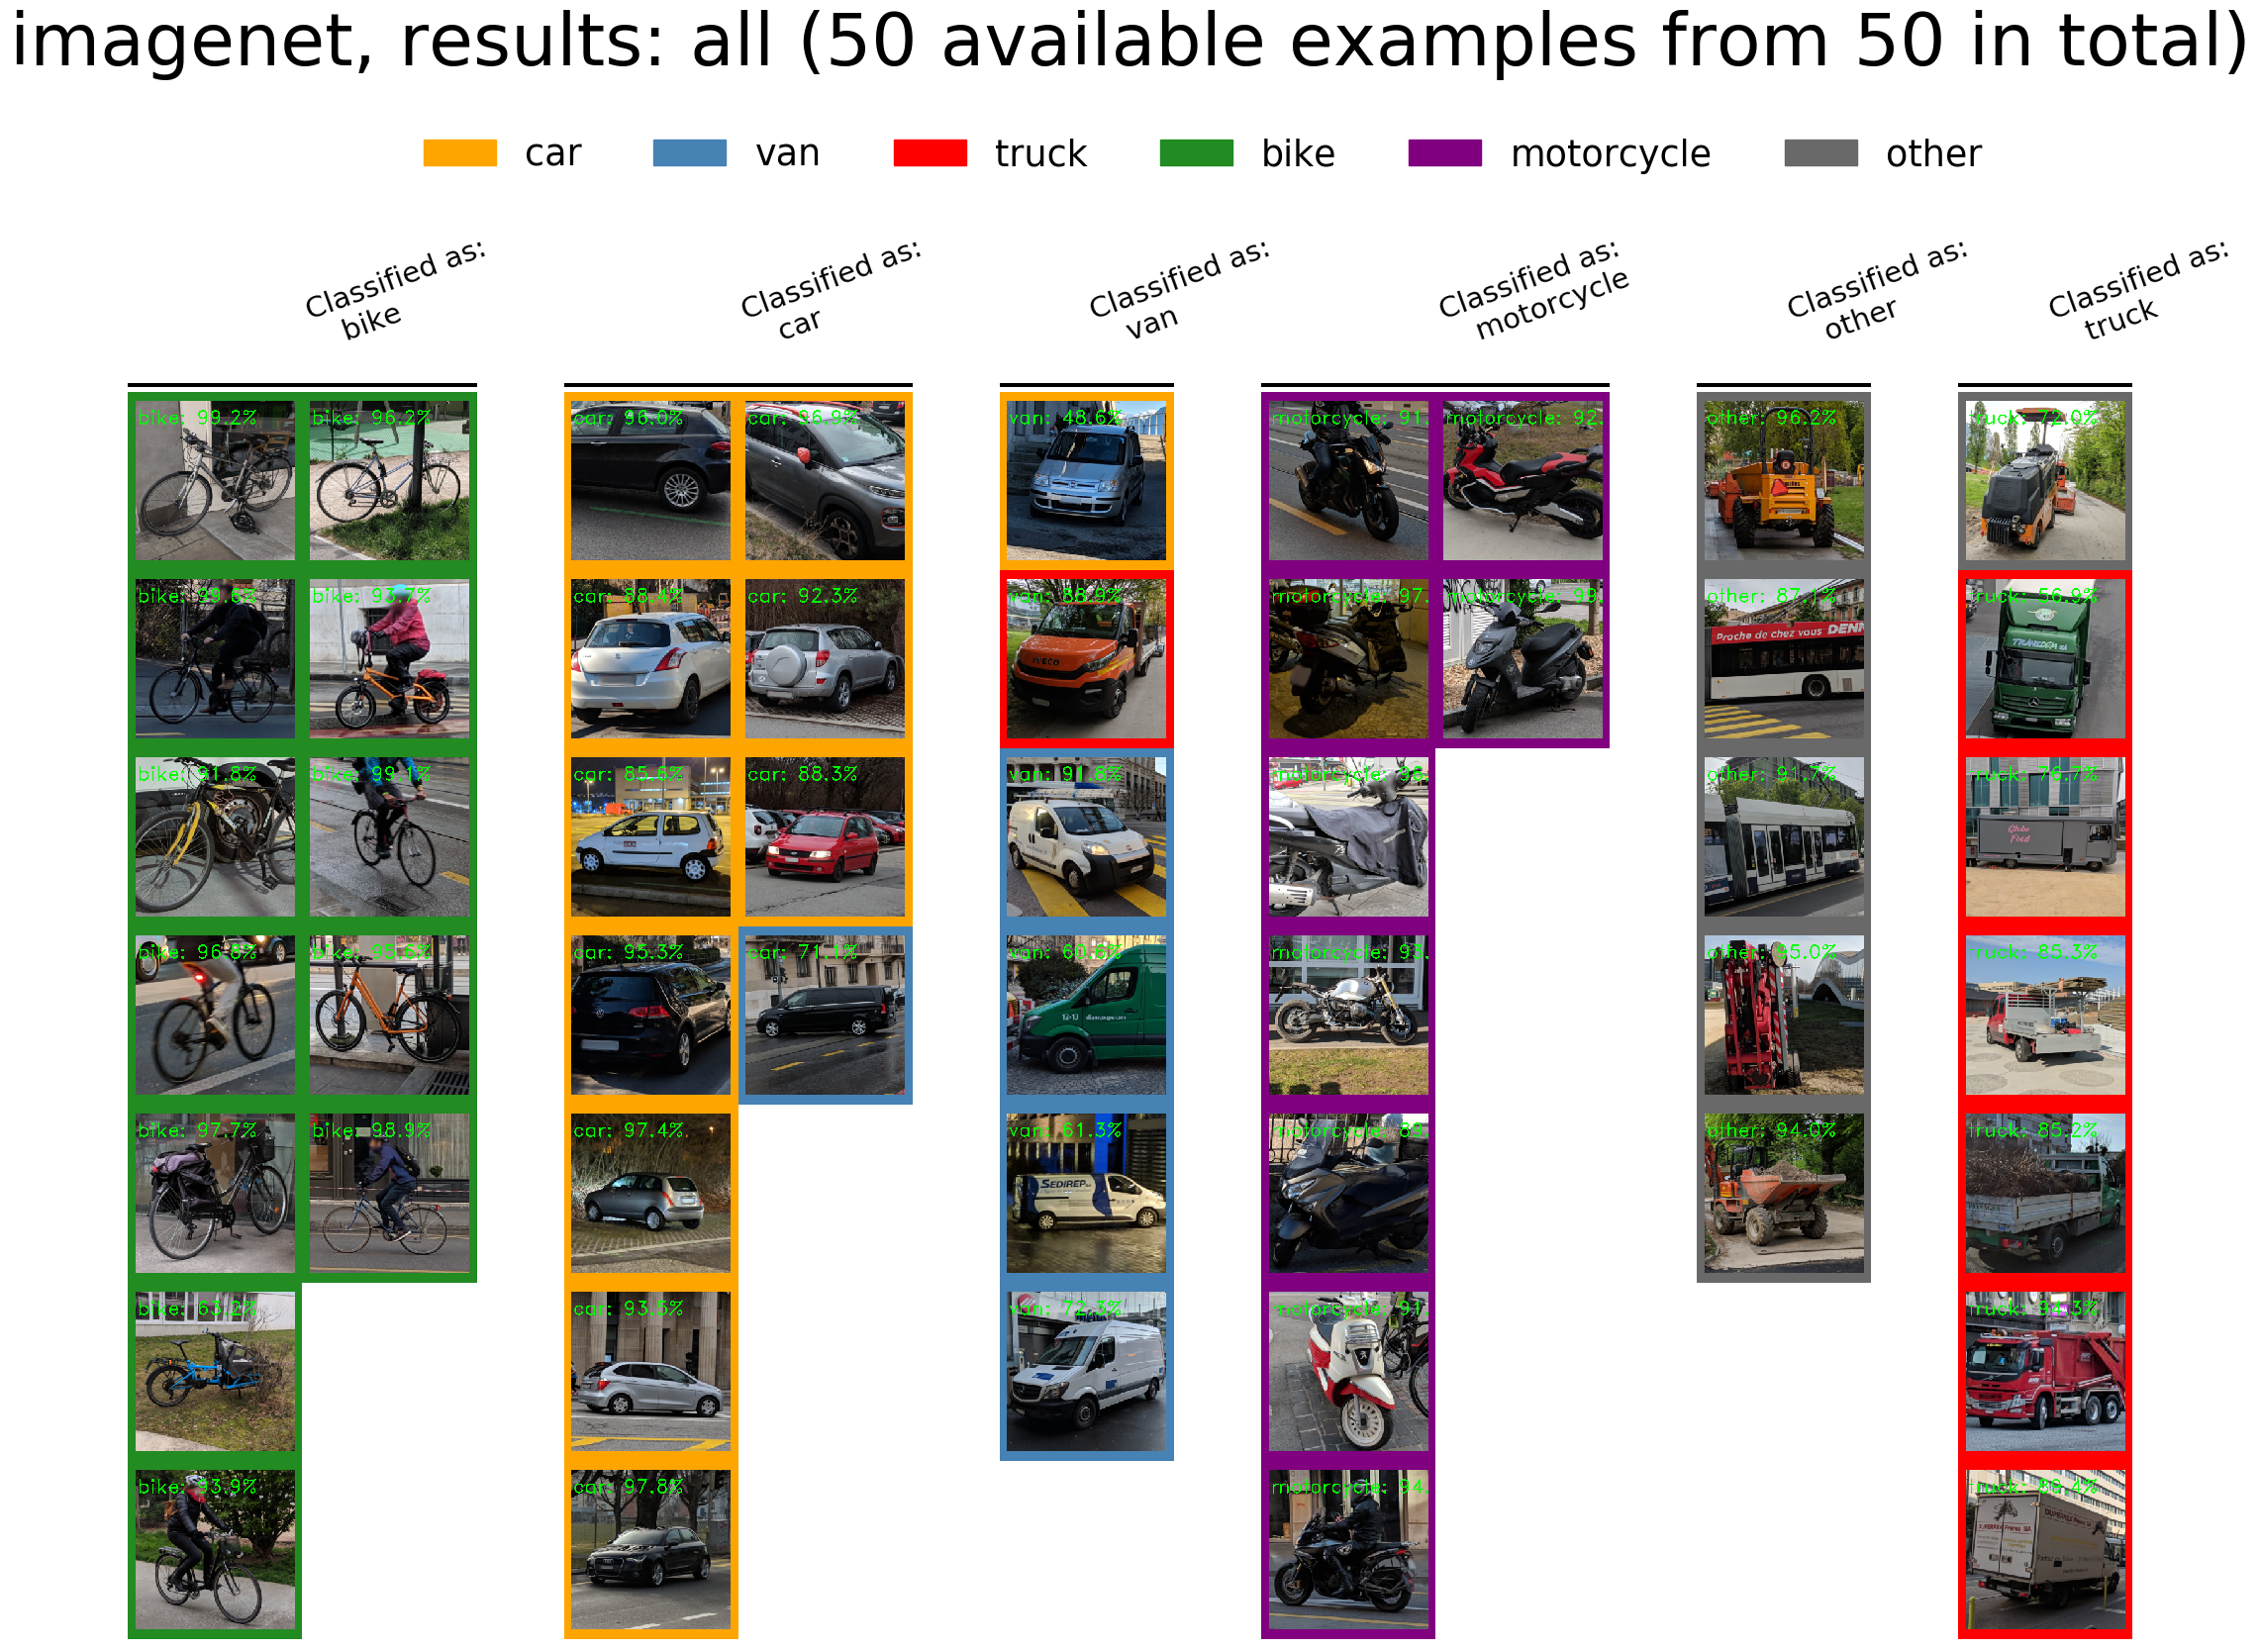

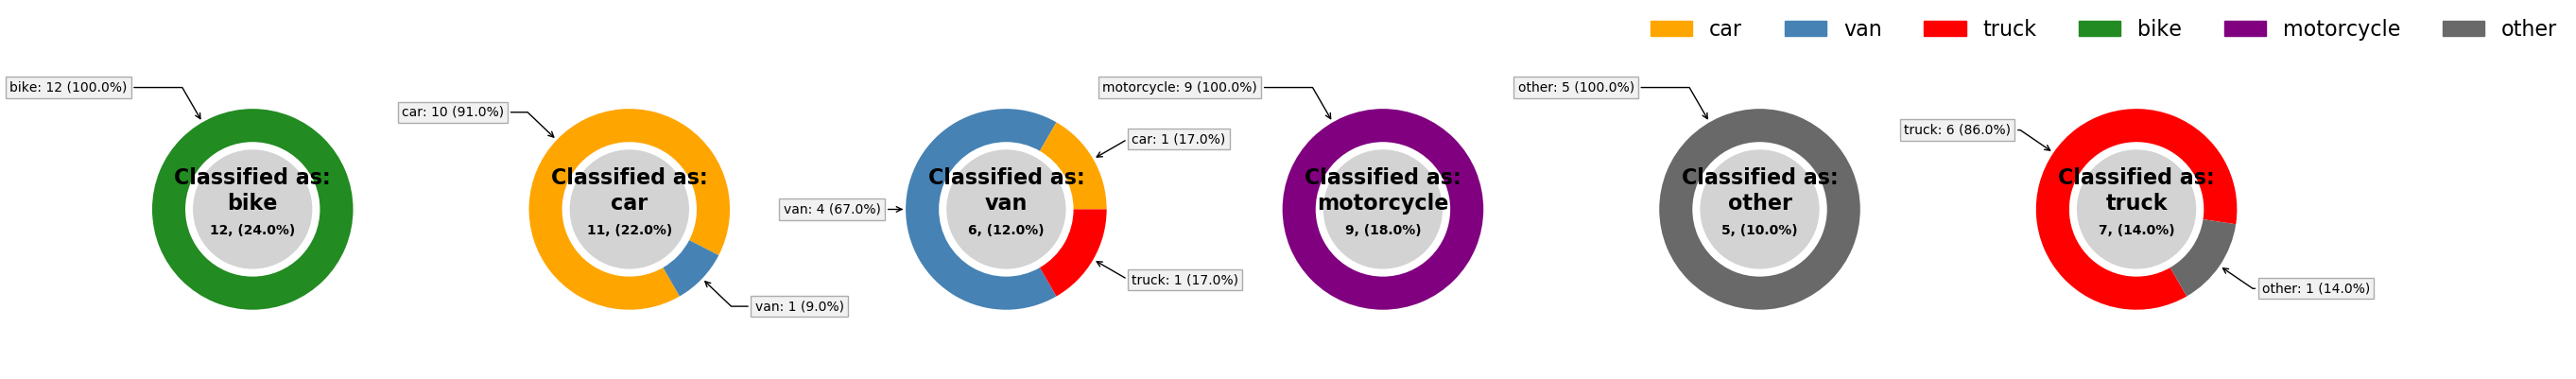

In [15]:
model_ID = 6

# load model_predictions_dict
os.chdir(PATH_results)
with open(f"{task_name}__{module_names[0]}__{dataset_name}__model_predictions_dict.p", 'rb') as file: # wb - write binary,
    model_predictions_dict  = pickle.load(file) 
          
plot_examples_with_predictions_and_proba_gamma( 
    model_ID=model_ID,
    model_predictions_dict= model_predictions_dict, 
    module_name=module_names[0], 
    dataset_name=dataset_name,                              
    subset_name=["test"], # denotes test predicitons made for test_subset_names
    img_batch_subset_names=test_subset_names, 
    path_to_raw_img_batch=PATH_raw,
    class_colors=class_colors,
    make_plot_with_img_examples=True, # use False, to have only pie charts with classyfication summary                                         
    max_img_per_col=7,
    plot_classyfication_summary=True
)